In [3]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

from tqdm import tqdm
%config InlineBackend.figure_formats = ['svg']

In [4]:
df = pd.read_csv("data.csv")
df["x"] = (df["x"] - 0.5) * 20
df["y"] *= 20

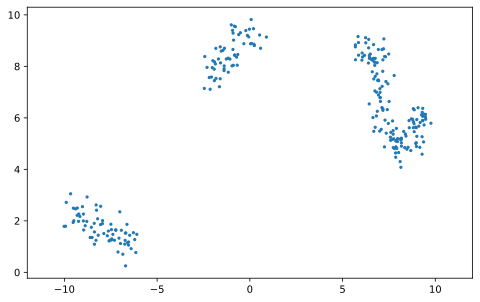

In [5]:
plt.figure(figsize=(8, 5))
plt.scatter(df["x"], df["y"], s=5)
plt.xlim(-12, 12)
plt.show()

In [39]:
x = np.hstack([df.to_numpy()[:,0].reshape(-1, 1), df.to_numpy()[:,0].reshape(-1, 1) ** 2])
y = df.to_numpy()[:,1].reshape(-1, 1)

temp = 15
x_test = np.hstack([np.linspace(-temp, temp, 400).reshape(-1, 1), np.linspace(-temp, temp, 400).reshape(-1, 1) ** 2])

x_torch = torch.from_numpy(x).float()
y_torch = torch.from_numpy(y).float()
x_test_torch = torch.from_numpy(x_test).float()

train_ds = TensorDataset(x_torch, y_torch)
train_dl = DataLoader(train_ds, batch_size=262)

In [14]:
len(x)

272

In [15]:
class NN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 200),  # 200
            nn.ReLU(),
            nn.Linear(200, 200),  # 50
            nn.ReLU(),
            nn.Linear(200, 200),  # 50
            nn.ReLU(),
            nn.Linear(200, 200),  # 50
            nn.ReLU(),
            nn.Linear(200, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

In [16]:
for i in tqdm(range(50)):
    model = NN()
    opt = optim.Adam(model.parameters(), lr=5e-5)
    for epoch in range(500):
        losses = []
        for xb, yb in train_dl:
            yb_pred = model(xb)
            loss = torch.mean((yb_pred - yb) ** 2)
            losses.append(float(loss))
            opt.zero_grad()
            loss.backward()
            opt.step()
    torch.save(model.state_dict(), f"./models/{i}.pth")

 12%|█████                                     | 6/50 [00:39<04:46,  6.50s/it]


KeyboardInterrupt: 

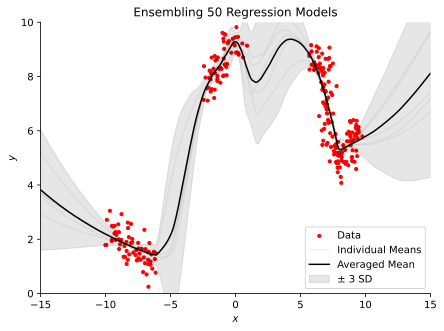

In [19]:
plt.figure(figsize=(7, 5))
plt.scatter(df["x"], df["y"], s=10, color='red', label="Data")
plt.xlim(-temp, temp)
plt.ylim(0,10)

preds_s = np.zeros((5, 400))

for i in range(5):
    model = NN()
    model.load_state_dict(torch.load(f"./models/{i}.pth"))
    model.eval()
    preds = model(x_test_torch).detach().numpy()[:,0]
    preds_s[i] = preds
    if i == 0:
        plt.plot(x_test[:,0].reshape(-1), preds, color='black', alpha=0.05, label="Individual Means")
    else:
        plt.plot(x_test[:,0].reshape(-1), preds, color='black', alpha=0.05)

plt.plot(x_test[:,0].reshape(-1), preds_s.mean(axis=0), color='black', label="Averaged Mean")
plt.fill_between(x_test[:,0].reshape(-1), 
                 preds_s.mean(axis=0) + 3 * preds_s.std(axis=0), 
                 preds_s.mean(axis=0) - 3 * preds_s.std(axis=0), 
                 color='black', label="$\pm$ 3 SD", alpha=0.1)

# plt.grid()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend(loc="lower right")

plt.title("Ensembling 50 Regression Models")

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
    
plt.show()

In [20]:
## visualize approximate posterior predictive

In [21]:
model = NN()
v = torch.nn.utils.parameters_to_vector(model.parameters()).detach()

In [22]:
model = NN()
v.requires_grad = True
torch.nn.utils.vector_to_parameters(v, model.parameters())

In [23]:
list(model.parameters())[0].sum().backward()

In [24]:
v

tensor([ 0.0388, -0.5803, -0.0463,  ...,  0.0288,  0.0164, -0.0495],
       requires_grad=True)

In [25]:
v.grad

In [26]:
len(list(model.parameters()))

10

In [27]:
print(list(model.parameters())[0].shape)
print(list(model.parameters())[1].shape)
print(list(model.parameters())[2].shape)
print(list(model.parameters())[3].shape)

torch.Size([200, 2])
torch.Size([200])
torch.Size([200, 200])
torch.Size([200])


In [65]:
class PolygonalChain(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        model_1 = NN()
        model_1.load_state_dict(torch.load("./models/0.pth"))
        self.m1_params = [mat.detach() for mat in list(model_1.parameters())]
    
        model_2 = NN()
        model_2.load_state_dict(torch.load("./models/3.pth"))
        self.m2_params = [mat.detach() for mat in list(model_2.parameters())]

#         self.layers = nn.Sequential(
#             nn.Linear(2, 200),  # 200
#             nn.ReLU(),
#             nn.Linear(200, 200),  # 50
#             nn.ReLU(),
#             nn.Linear(200, 200),  # 50
#             nn.ReLU(),
#             nn.Linear(200, 200),  # 50
#             nn.ReLU(),
#             nn.Linear(200, 1)
#         )
        model_3 = NN()
        model_3.load_state_dict(torch.load("./models/2.pth"))
        self.params = list(model_3.parameters())
        # self.params = list(self.parameters())
        
    def forward(self, x, t=None):
        
        if t is None:
            t = np.random.uniform(0, 1)
        
        if t <= 0.5:
            new_params = [2 * (t * mat + (0.5 - t) * mat1) for mat, mat1 in zip(self.params, self.m1_params)]
        else:
            new_params = [2 * ((t - 0.5) * mat2 + (1 - t) * mat) for mat, mat2 in zip(self.params, self.m2_params)]
        
        x = torch.nn.functional.relu(new_params[0] @ x + new_params[1].view(-1, 1))
        x = torch.nn.functional.relu(new_params[2] @ x + new_params[3].view(-1, 1))
        x = torch.nn.functional.relu(new_params[4] @ x + new_params[5].view(-1, 1))
        x = torch.nn.functional.relu(new_params[6] @ x + new_params[7].view(-1, 1))
        
        return new_params[8] @ x + new_params[9].view(-1, 1)

In [68]:
pc = PolygonalChain()
opt = optim.Adam(pc.params, lr=1e-3)
for epoch in range(2000):
    losses = []
    for xb, yb in train_dl:
        yb_pred = pc(xb.T).view(-1)
        loss = torch.mean((yb_pred - yb) ** 2)
        losses.append(float(loss))
        opt.zero_grad()
        loss.backward()
        opt.step()
    print(epoch, np.mean(losses))

0 91.29389953613281
1 18.139222145080566
2 29.165761590003967
3 47.794875144958496
4 36.81048011779785
5 14.181056022644043
6 9.899930715560913
7 16.88290226459503
8 21.170870780944824
9 16.255561351776123
10 16.61435627937317
11 8.965266704559326
12 65.77876377105713
13 21.48374319076538
14 11.022584676742554
15 9.203867197036743
16 10.47204303741455
17 13.759162902832031
18 9.73011302947998
19 13.30072021484375
20 5.97156834602356
21 10.083209037780762
22 8.824803873896599
23 6.45813974738121
24 9.418644577264786
25 43.341896057128906
26 8.542944610118866
27 6.984650433063507
28 12.240938663482666
29 13.133015394210815
30 11.863188743591309
31 8.570754915475845
32 6.871216416358948
33 5.1662561148405075
34 6.537929326295853
35 7.1447087824344635
36 7.418647289276123
37 12.373292922973633
38 10.43887734413147
39 10.232243299484253
40 7.903296113014221
41 9.916000247001648
42 14.858440399169922
43 7.8594924211502075
44 8.260251194238663
45 8.420625984668732
46 6.8877681493759155
47 6.2

378 5.260138049721718
379 5.665441244840622
380 5.326958060264587
381 6.194639563560486
382 5.48640513420105
383 6.044554457068443
384 4.863234490156174
385 4.86766816675663
386 5.003055825829506
387 4.568378955125809
388 4.87249693274498
389 4.832307413220406
390 6.226320147514343
391 6.459370851516724
392 5.300265997648239
393 4.930429100990295
394 4.792687863111496
395 4.765019439160824
396 5.620881259441376
397 4.602109521627426
398 5.005686700344086
399 5.097595930099487
400 5.292098060250282
401 4.9689551293849945
402 5.852331727743149
403 4.754037991166115
404 6.008060783147812
405 5.289459988474846
406 4.495631918311119
407 4.528556317090988
408 6.23753559589386
409 4.4389394372701645
410 4.761900395154953
411 4.8183359652757645
412 5.60557921230793
413 4.879688128829002
414 5.376704156398773
415 5.007437884807587
416 4.37513093650341
417 5.728122115135193
418 4.872587233781815
419 4.785436704754829
420 4.491300642490387
421 6.722275644540787
422 6.980558440089226
423 4.7223078

757 4.698538392782211
758 6.3079071044921875
759 6.624920964241028
760 4.56927427649498
761 4.598911516368389
762 5.543809771537781
763 5.24133625626564
764 4.67351371049881
765 4.235492646694183
766 4.472746230661869
767 5.359923034906387
768 4.617958843708038
769 7.3085644617676735
770 5.428845852613449
771 4.3834424912929535
772 4.69710910320282
773 4.476780265569687
774 4.760295286774635
775 6.178472876548767
776 4.322678655385971
777 4.66136622428894
778 4.5360201597213745
779 5.311174273490906
780 4.579022705554962
781 4.314488470554352
782 4.481356114149094
783 4.703783601522446
784 4.699847519397736
785 4.41090964525938
786 4.486060798168182
787 4.711401805281639
788 4.814965337514877
789 4.439202502369881
790 4.795098006725311
791 4.634150229394436
792 4.429347783327103
793 4.336792528629303
794 4.79598206281662
795 4.596942156553268
796 4.254839442670345
797 4.333206698298454
798 4.521305680274963
799 4.8472320437431335
800 4.878514409065247
801 4.039185866713524
802 4.622671

1134 4.439367860555649
1135 5.739922389388084
1136 4.311894111335278
1137 4.2833521515131
1138 4.689500868320465
1139 4.4025463461875916
1140 4.49101135134697
1141 4.414442658424377
1142 4.516061082482338
1143 4.804823011159897
1144 4.842209905385971
1145 5.252324134111404
1146 4.747939229011536
1147 4.944512724876404
1148 4.203775055706501
1149 8.178586959838867
1150 4.701279938220978
1151 5.675325781106949
1152 9.353592157363892
1153 8.452313423156738
1154 5.872754439711571
1155 4.948853403329849
1156 6.668641448020935
1157 4.678414784371853
1158 4.869378551840782
1159 4.64983943104744
1160 5.047157108783722
1161 9.820278018712997
1162 6.477660655975342
1163 5.2256318256258965
1164 5.68432754278183
1165 6.70331084728241
1166 5.520090788602829
1167 5.226521819829941
1168 4.720438852906227
1169 6.366678714752197
1170 5.896780431270599
1171 5.880749940872192
1172 7.521947860717773
1173 5.609955310821533
1174 4.333183407783508
1175 4.094380035996437
1176 4.222151666879654
1177 4.81371849

1498 4.313543990254402
1499 3.9124756045639515
1500 4.117876261472702
1501 4.233710512518883
1502 4.416857659816742
1503 4.787434011697769
1504 4.081852212548256
1505 4.964440435171127
1506 4.2248455211520195
1507 6.16609799861908
1508 5.3146889209747314
1509 4.682565778493881
1510 5.735864877700806
1511 5.3050854206085205
1512 4.500580191612244
1513 4.772695064544678
1514 4.469849571585655
1515 4.490056097507477
1516 4.535103380680084
1517 4.351011574268341
1518 4.108160078525543
1519 5.1535404324531555
1520 5.434023022651672
1521 4.5982456505298615
1522 5.267990797758102
1523 5.840460658073425
1524 5.070462606847286
1525 4.734249457716942
1526 5.158178448677063
1527 4.4500864297151566
1528 4.3316677287220955
1529 5.437736630439758
1530 4.393773108720779
1531 4.370952904224396
1532 4.366935074329376
1533 4.31050568819046
1534 6.297800540924072
1535 4.697288125753403
1536 5.795129776000977
1537 4.972570672631264
1538 5.423890024423599
1539 3.9939724430441856
1540 6.021203279495239
1541

1861 4.299082055687904
1862 4.148173108696938
1863 4.0690799206495285
1864 4.680798232555389
1865 4.264474593102932
1866 4.25285479426384
1867 5.147768296301365
1868 4.1023759469389915
1869 4.472830846905708
1870 4.0526649951934814
1871 3.9445327818393707
1872 4.163454696536064
1873 4.3001497983932495
1874 4.084933780133724
1875 4.026133447885513
1876 4.055315360426903
1877 4.156616270542145
1878 4.953819394111633
1879 5.067216970026493
1880 4.380574427545071
1881 4.11496265232563
1882 4.148054927587509
1883 4.497343301773071
1884 4.206511490046978
1885 4.908214688301086
1886 3.962059259414673
1887 4.188789546489716
1888 4.137248158454895
1889 4.370134264230728
1890 4.18761533498764
1891 4.591739743947983
1892 4.707360327243805
1893 4.544822573661804
1894 4.320237398147583
1895 4.504321001470089
1896 5.186430186033249
1897 4.484209522604942
1898 4.211389183998108
1899 4.846587896347046
1900 5.390709742903709
1901 4.410755276679993
1902 4.38966266810894
1903 4.224295079708099
1904 4.122

In [56]:
pc = PolygonalChain()

In [57]:
import matplotlib.cm as cm

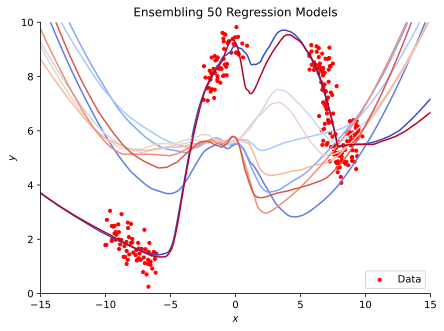

In [70]:
plt.figure(figsize=(7, 5))
plt.scatter(df["x"], df["y"], s=10, color='red', label="Data")
plt.xlim(-temp, temp)
plt.ylim(0, 10)

preds_s = np.zeros((50, 400))

# for i in range(50):
#     model = NN()
#     model.load_state_dict(torch.load(f"./models/{i}.pth"))
#     model.eval()
#     preds = model(x_test_torch).detach().numpy()[:,0]
#     preds_s[i] = preds
#     if i == 0:
#         plt.plot(x_test[:,0].reshape(-1), preds, color='black', alpha=0.05, label="Individual Means")
#     else:
#         plt.plot(x_test[:,0].reshape(-1), preds, color='black', alpha=0.05)
        
color = cm.coolwarm(np.linspace(0, 1, 10))
for i, t in enumerate(np.linspace(0, 1, 10)):
    preds = pc(x_test_torch.T, t=t).view(-1).detach().numpy()
    plt.plot(x_test[:, 0].reshape(-1), preds, c=color[i])
        
# plt.plot(x_test[:,0].reshape(-1), preds_s.mean(axis=0), color='black', label="Averaged Mean")
# plt.fill_between(x_test[:,0].reshape(-1), 
#                  preds_s.mean(axis=0) + 3 * preds_s.std(axis=0), 
#                  preds_s.mean(axis=0) - 3 * preds_s.std(axis=0), 
#                  color='black', label="$\pm$ 3 SD", alpha=0.1)
# plt.grid()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend(loc="lower right")

plt.title("Ensembling 50 Regression Models")

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
    
plt.show()